# Module 1.12: Portfolio Architecture — The Strategic View

> **Goal:** Triage the portfolio into actionable archetypes and identify where risk and investment live.

### Building on 1.10

| 1.10 Computed | 1.12 Uses It To |
|---------------|----------------|
| `structure_score` | Assign archetypes (X-axis) |
| `chaos_score` | Assign archetypes (Y-axis) |
| `sb_quadrant` | Cross-reference with LD6 |
| Hierarchy columns | Risk matrix by department |

### The Four Archetypes

```
                         CHAOS SCORE
                    Low              High
               ┌───────────────┬───────────────┐
               │               │               │
      High     │   COMPLEX     │    MESSY      │
   S           │  Has pattern  │  Has pattern  │
   T           │  low noise    │  high noise   │
   R           │  → Invest     │  → Robust     │
   U           ├───────────────┼───────────────┤
   C           │               │               │
   T   Low     │   STABLE      │  LOW SIGNAL   │
   U           │  No pattern   │  No pattern   │
   R           │  predictable  │  chaotic      │
   E           │  → Baseline   │  → Aggregate  │
               └───────────────┴───────────────┘
```

**5Q Lens:** Q5 (Ownership) — Who owns these forecasts and how should we invest?

---

## 1. Setup

In [1]:
import warnings
import json
import matplotlib.pyplot as plt

import forecast_foundations as ff
from tsforge.plots.eda.portfolio import (
    # Data processing
    add_abc_classification,
    compute_abc_mismatch,
    assign_archetypes,
    select_archetype_examples,
    select_heroes,
    # Plotting
    plot_strategic_map,
    plot_archetype_examples,
    plot_archetype_comparison,
    plot_heroes_on_map,
    plot_hero_timeseries,
    plot_portfolio_composition,
    plot_abc_mismatch_heatmap,
    plot_risk_matrix,
    plot_risk_heatmap,
    plot_department_aggregates,
    # Utilities
    generate_risk_insights,
    print_abc_summary,
    print_mismatch_summary,
    ARCHETYPE_COLORS,
)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

env = ff.setup_notebook()
output = env.output

✓ Setup complete | Root: real-world-forecasting-foundations | Notebook: 1.12_portfolio_architecture | Data: /Users/lindsaytruong/forecast-academy/real-world-forecasting-foundations/data | Cache: on


---

## 2. Load 1.10 Scores

In [2]:
# Load scores from 1.10
scores_df = output.load('1.10_lie_detector')

# Load weekly data for volume calculation and plots
weekly_df = output.load('1.08_data_preparation')

print(f"Scores: {scores_df.shape[0]:,} series")
print(f"Weekly: {weekly_df.shape[0]:,} rows")

✓ Loaded '1.10_lie_detector'
   Shape: 30,490 × 25
✓ Loaded '1.08_data_preparation'
   Shape: 6,848,887 × 21
Scores: 30,490 series
Weekly: 6,848,887 rows


---

## 3. ABC Segmentation (Volume vs Revenue)

<div style="background: #fff3cd; border-left: 4px solid #ffc107; padding: 15px; margin: 15px 0;">
<strong>⚠️ Key Insight: Units ≠ Dollars</strong><br><br>
Forecast accuracy is typically measured on <strong>units</strong>.<br>
But the business is measured on <strong>dollars</strong>.<br><br>
A 10% error on a $100 item hurts more than a 10% error on a $1 item.<br>
ABC segmentation should reflect <em>what the business actually cares about</em>.
</div>

| Segmentation | Measures | Use When |
|--------------|----------|----------|
| **ABC-Volume** | Total units sold | Optimizing logistics, warehouse space |
| **ABC-Revenue** | Total $ sales | Optimizing financial outcomes, margin |

In [3]:
# Add ABC classification (both volume and revenue)
portfolio_df = add_abc_classification(scores_df, weekly_df)

# Print summary
print_abc_summary(portfolio_df)

ABC by VOLUME (what forecasts are measured on)
Class      Series     % Series     % Volume
-------------------------------------------------------
A           9,305        30.5%        80.0%
B           9,808        32.2%        15.0%
C          11,377        37.3%         5.0%


ABC by REVENUE (what the business is measured on)
Class      Series     % Series    % Revenue
-------------------------------------------------------
A           9,305        30.5%        80.0%
B           9,808        32.2%        15.0%
C          11,377        37.3%         5.0%


### 3.1 The Volume vs Revenue Mismatch

In [4]:
# Analyze mismatch
mismatch_info = compute_abc_mismatch(portfolio_df)
print_mismatch_summary(mismatch_info)

Items Where Volume ≠ Revenue Priority

🔵 HIDDEN VALUE (2 items)
   Volume: B/C class, Revenue: A class
   → Lower unit volume but HIGH dollar impact
   → Forecast errors here hurt the business more than accuracy metrics show

🟡 OVER-INDEXED (2 items)
   Volume: A class, Revenue: B/C class
   → High unit volume but LOWER dollar impact
   → Optimizing accuracy here may not move business KPIs

Alignment: 100.0% same ABC class
Mismatch:  0.0% differ


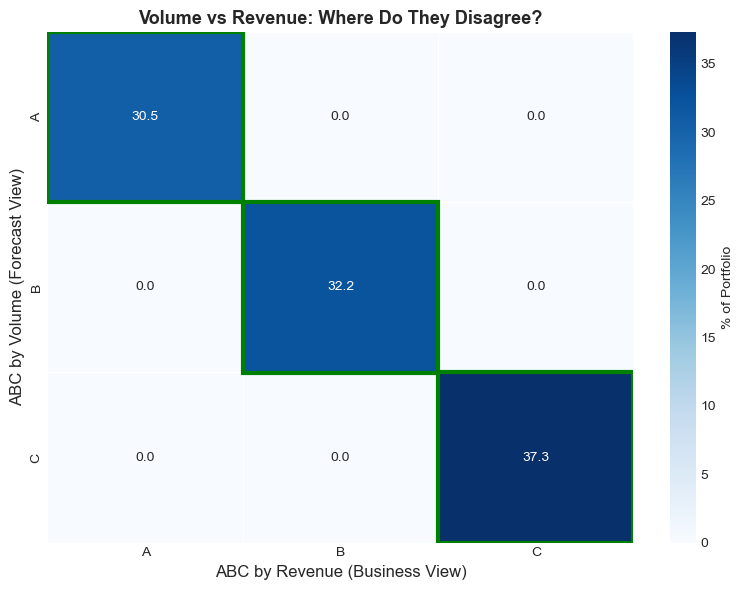

Green boxes = Aligned (same ABC class for volume and revenue)
Off-diagonal = Misaligned (volume priority ≠ revenue priority)


In [5]:
# Visualize mismatch
fig = plot_abc_mismatch_heatmap(mismatch_info['mismatch_matrix'])
plt.show()

print("Green boxes = Aligned (same ABC class for volume and revenue)")
print("Off-diagonal = Misaligned (volume priority ≠ revenue priority)")

### 3.2 Implication for Forecast Strategy

| Scenario | Volume ABC | Revenue ABC | What It Means | Strategy |
|----------|------------|-------------|---------------|----------|
| **Aligned** | A | A | High volume AND high revenue | Priority focus |
| **Hidden Value** | B/C | A | Low volume, high price | Don't ignore — $ impact is real |
| **Over-indexed** | A | B/C | High volume, low price | Accuracy gains may not matter |
| **Low Priority** | C | C | Low volume AND low revenue | Baseline is fine |

> **Key Takeaway:** If your forecast accuracy metric is based on units, you might be optimizing the wrong 20% of the portfolio.

---

## 4. Archetype Assignment

In [6]:
# Assign archetypes using median-based thresholds
portfolio_df, struct_thresh, chaos_thresh = assign_archetypes(portfolio_df)

print(f"Thresholds (median-based):")
print(f"  Structure: {struct_thresh:.3f}")
print(f"  Chaos:     {chaos_thresh:.3f}")

print(f"\nArchetype Distribution:")
for arch in ['Stable', 'Complex', 'Messy', 'Low Signal']:
    n = (portfolio_df['archetype'] == arch).sum()
    pct = n / len(portfolio_df)
    print(f"  {arch:<12} {n:>8,}  ({pct:.1%})")

Thresholds (median-based):
  Structure: 0.467
  Chaos:     0.409

Archetype Distribution:
  Stable          6,202  (20.3%)
  Complex         9,043  (29.7%)
  Messy           6,202  (20.3%)
  Low Signal      9,043  (29.7%)


---

## 5. What Each Archetype Looks Like (Real M5 Examples)

Before diving into analysis, let's see **real examples** of each archetype.

In [7]:
# Select clear examples for each archetype
examples = select_archetype_examples(portfolio_df, n_examples=3)

### 5.1 STABLE — "The Easy Ones"

> **Low Structure + Low Chaos** = No strong pattern, but predictable anyway
>
> **Strategy:** Simple baselines work fine. Don't overthink it.

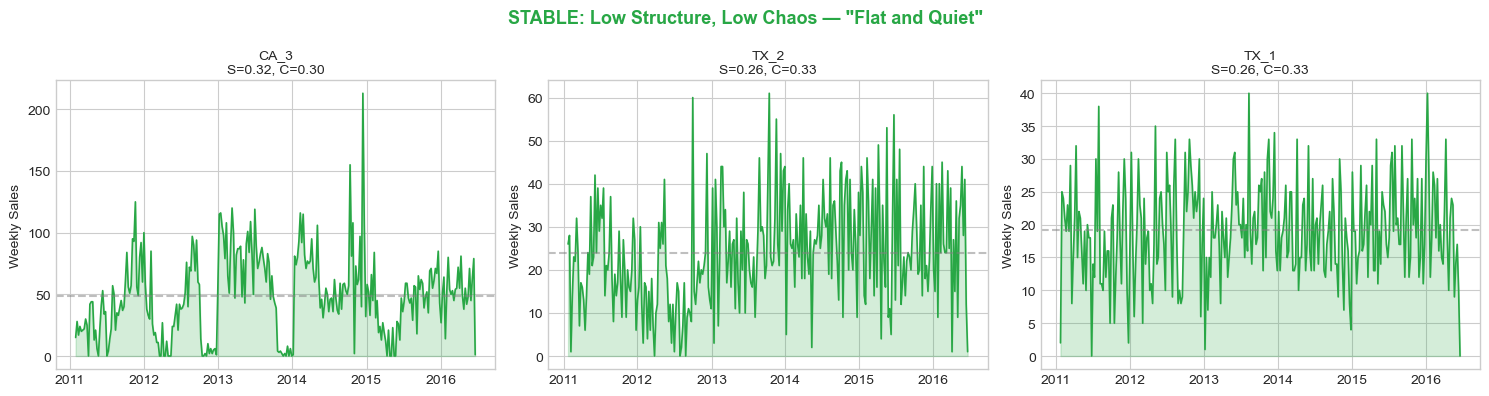

What you see: Relatively flat, low variability, hovers around the mean
Why it's easy: No complex pattern to learn — naive or moving average works


In [8]:
figs = plot_archetype_examples({'Stable': examples['Stable']}, weekly_df)
plt.show()

print("What you see: Relatively flat, low variability, hovers around the mean")
print("Why it's easy: No complex pattern to learn — naive or moving average works")

### 5.2 COMPLEX — "The Opportunity"

> **High Structure + Low Chaos** = Clear patterns with clean signal
>
> **Strategy:** Invest in ML. This is where models pay off.

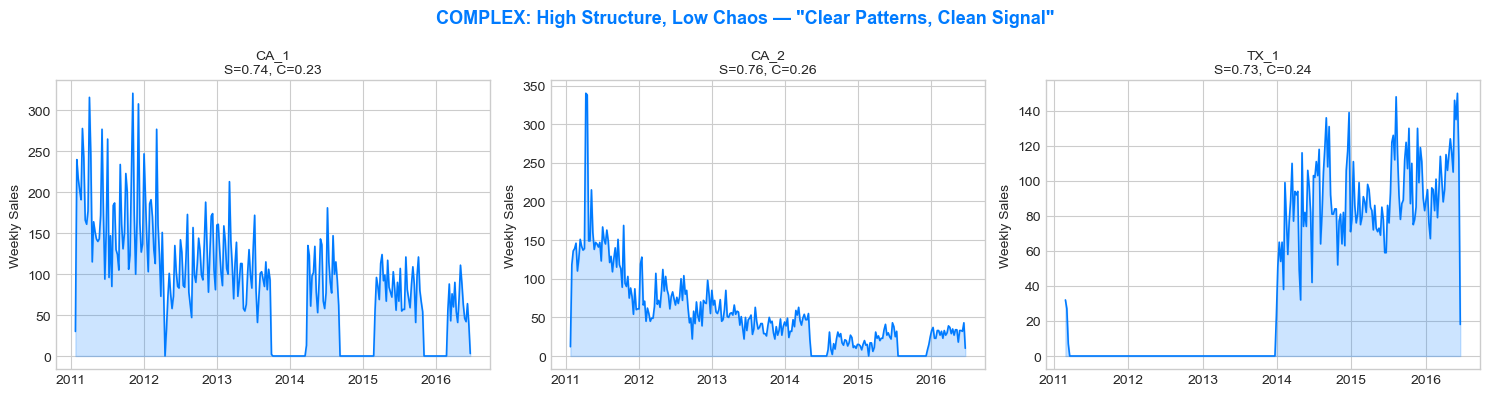

What you see: Visible seasonality, trends, or repeating patterns
Why it's opportunity: Models can learn the pattern — this is your ROI


In [9]:
figs = plot_archetype_examples({'Complex': examples['Complex']}, weekly_df)
plt.show()

print("What you see: Visible seasonality, trends, or repeating patterns")
print("Why it's opportunity: Models can learn the pattern — this is your ROI")

### 5.3 MESSY — "The Challenging Ones"

> **High Structure + High Chaos** = Pattern exists, but buried in noise
>
> **Strategy:** Robust methods, wide intervals, human oversight

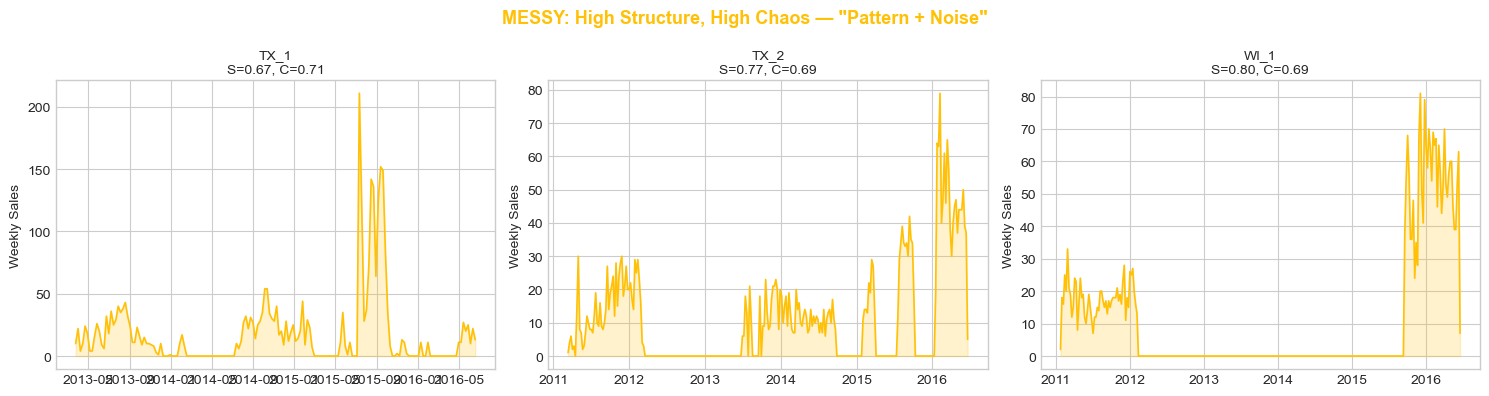

What you see: Some seasonality visible, but lots of spikes and variability
Why it's hard: Pattern is there but noise makes it unreliable


In [10]:
figs = plot_archetype_examples({'Messy': examples['Messy']}, weekly_df)
plt.show()

print("What you see: Some seasonality visible, but lots of spikes and variability")
print("Why it's hard: Pattern is there but noise makes it unreliable")

### 5.4 LOW SIGNAL — "The Difficult Ones"

> **Low Structure + High Chaos** = No pattern, high randomness
>
> **Strategy:** Don't try to forecast at item level. Aggregate up or use naive.

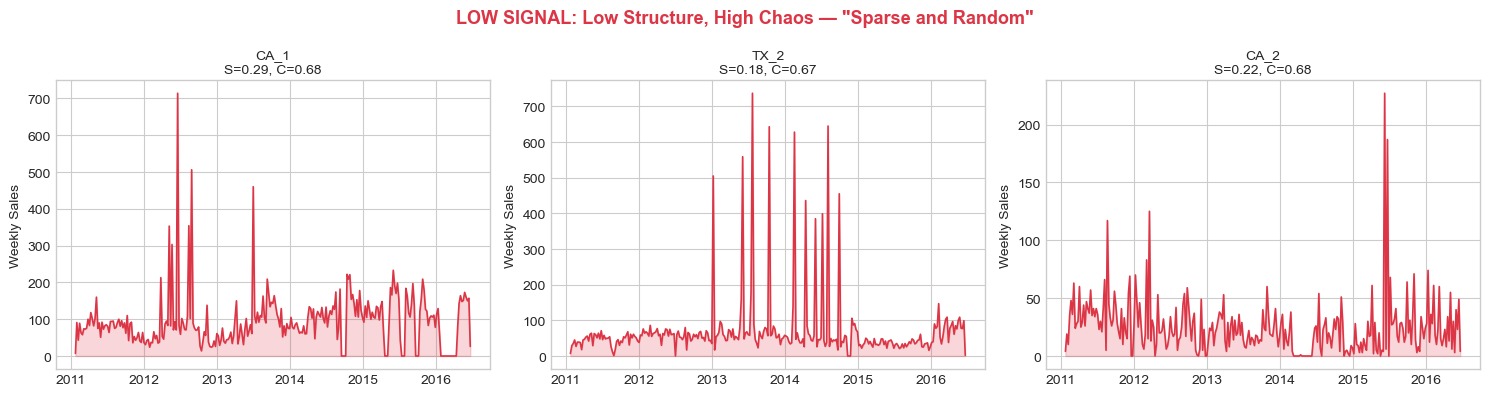

What you see: Intermittent, sparse, spiky, no discernible pattern
Why it's hard: No signal to learn — models will just fit noise


In [11]:
figs = plot_archetype_examples({'Low Signal': examples['Low Signal']}, weekly_df)
plt.show()

print("What you see: Intermittent, sparse, spiky, no discernible pattern")
print("Why it's hard: No signal to learn — models will just fit noise")

### 5.5 Side-by-Side Comparison

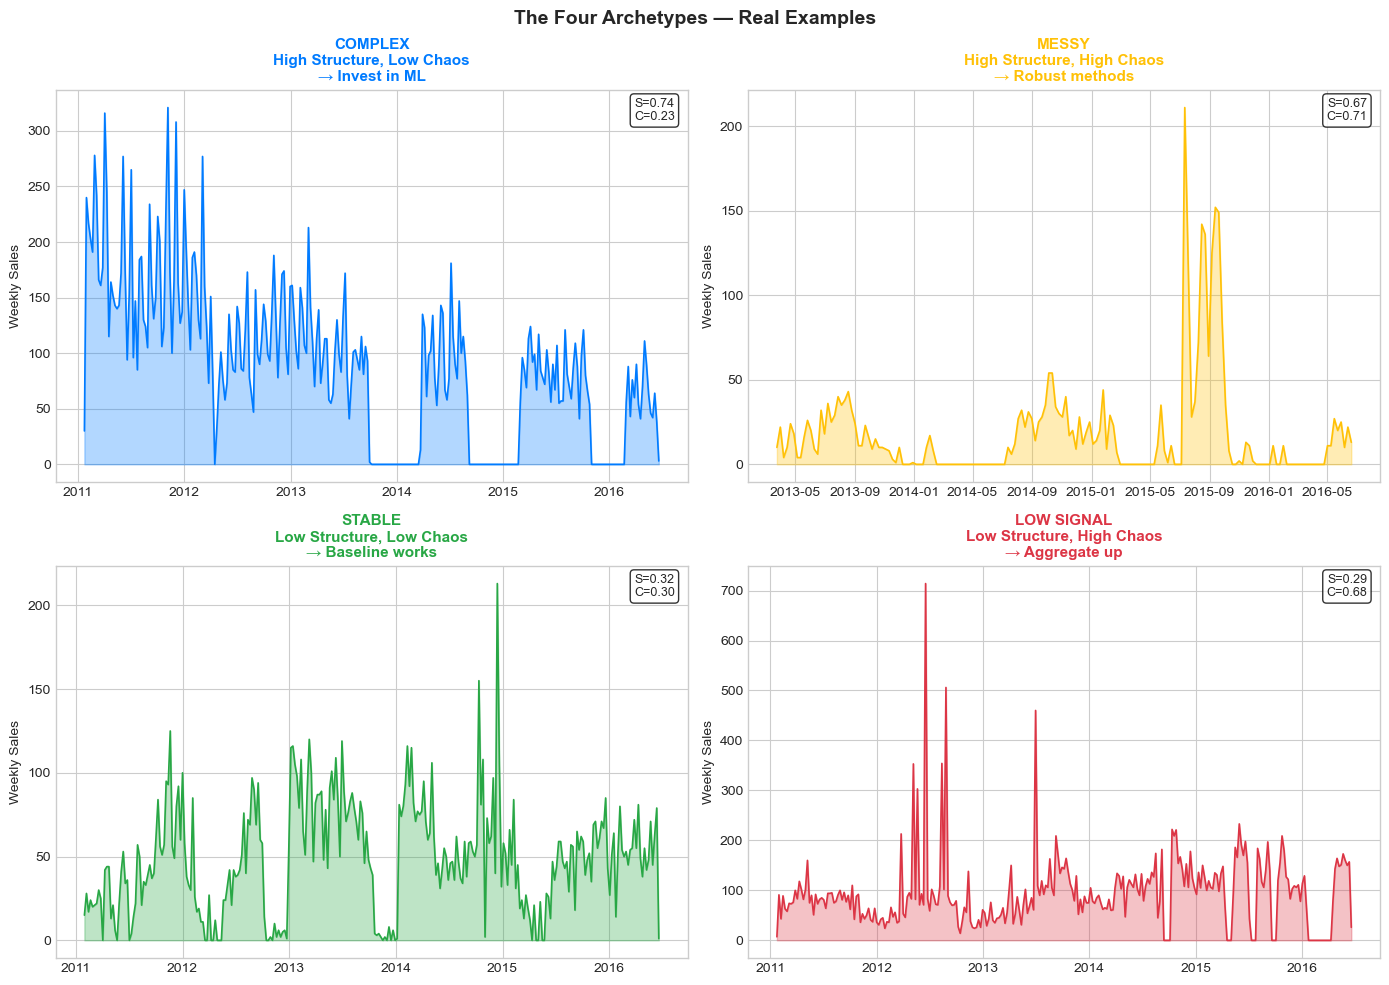

In [12]:
fig = plot_archetype_comparison(examples, weekly_df)
plt.show()

### 5.6 Archetype Decision Guide

| See This? | Archetype | Action |
|-----------|-----------|--------|
| Flat, quiet, hovers around mean | **Stable** | Automate with naive/MA |
| Clear waves, clean seasonality | **Complex** | Invest in ETS/ARIMA/ML |
| Waves visible but spiky/noisy | **Messy** | Robust + wide intervals |
| Sparse, intermittent, random | **Low Signal** | Aggregate or accept baseline |

---

## 6. The Strategic Map (Structure × Chaos)

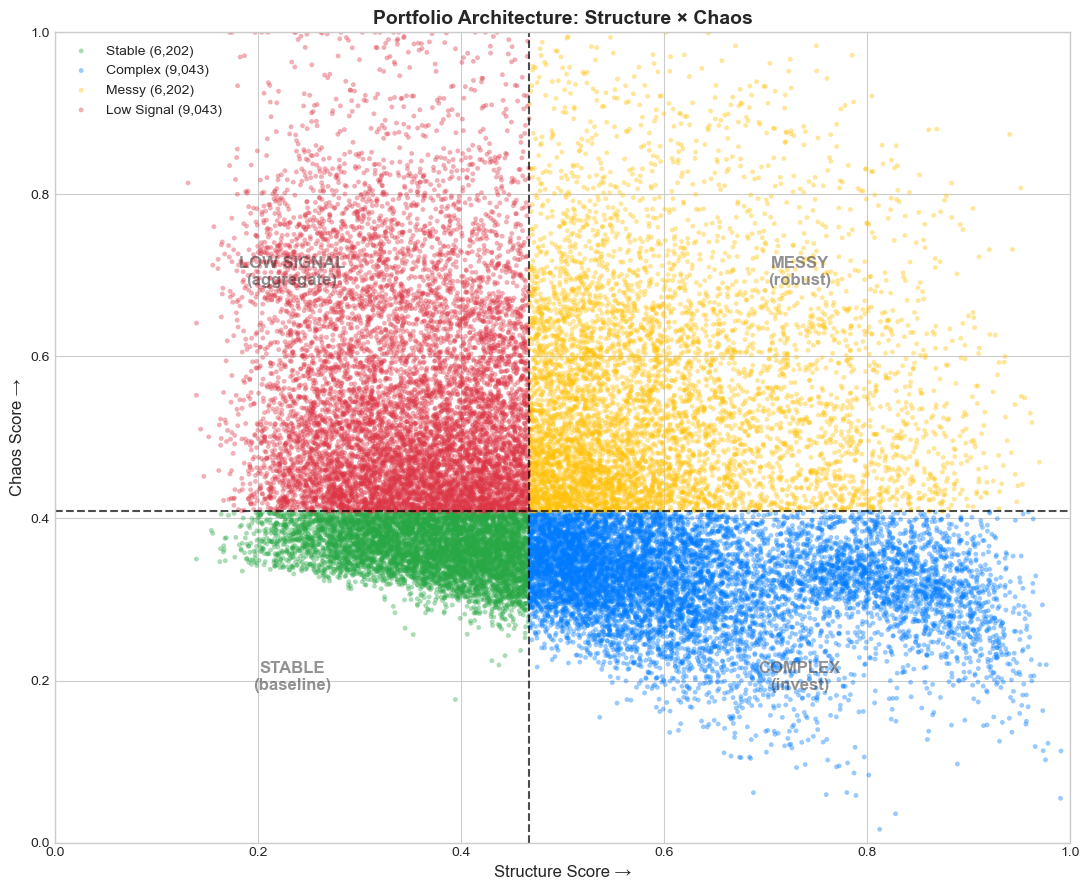

In [13]:
fig, ax = plot_strategic_map(portfolio_df, struct_thresh, chaos_thresh)
plt.show()

---

## 7. Hero Series (High-Volume Representatives)

In [14]:
heroes = select_heroes(portfolio_df)
print("Hero Series (high-volume representative per archetype):")
heroes

Hero Series (high-volume representative per archetype):


,archetype,unique_id,structure_score,chaos_score,total_volume
0,Stable,HOUSEHOLD_2_115_CA_2,0.387305,0.358985,3775.0
1,Complex,FOODS_3_120_CA_4,0.578891,0.315208,14364.0
2,Messy,FOODS_3_042_WI_2,0.565792,0.501404,12469.0
3,Low Signal,FOODS_3_474_CA_3,0.397006,0.467620,18340.0


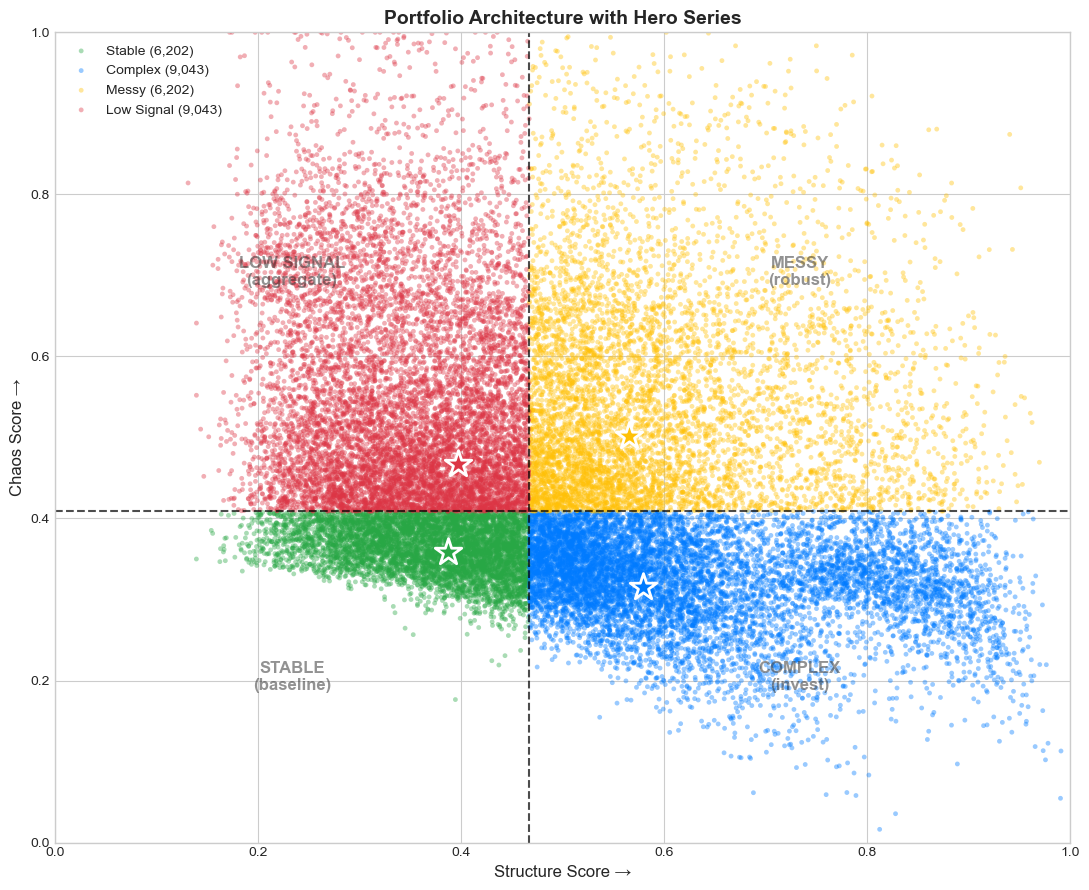

In [15]:
# Heroes on strategic map
fig = plot_heroes_on_map(portfolio_df, heroes, struct_thresh, chaos_thresh)
plt.show()

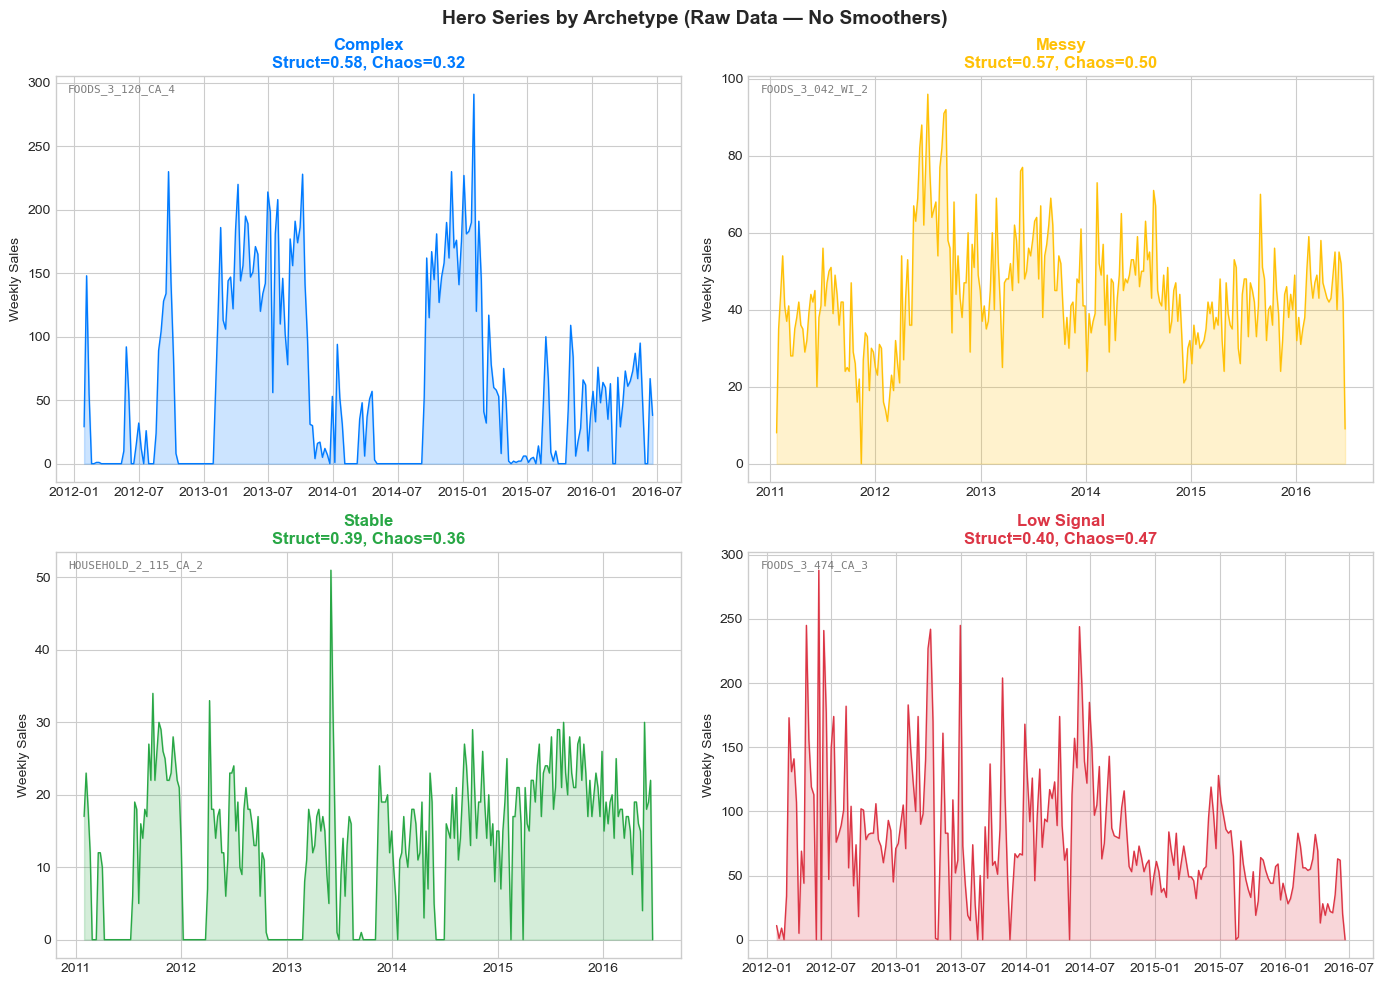

In [16]:
# Hero time series
fig = plot_hero_timeseries(heroes, weekly_df)
plt.show()

---

## 8. Portfolio Composition (SKUs vs Volume)

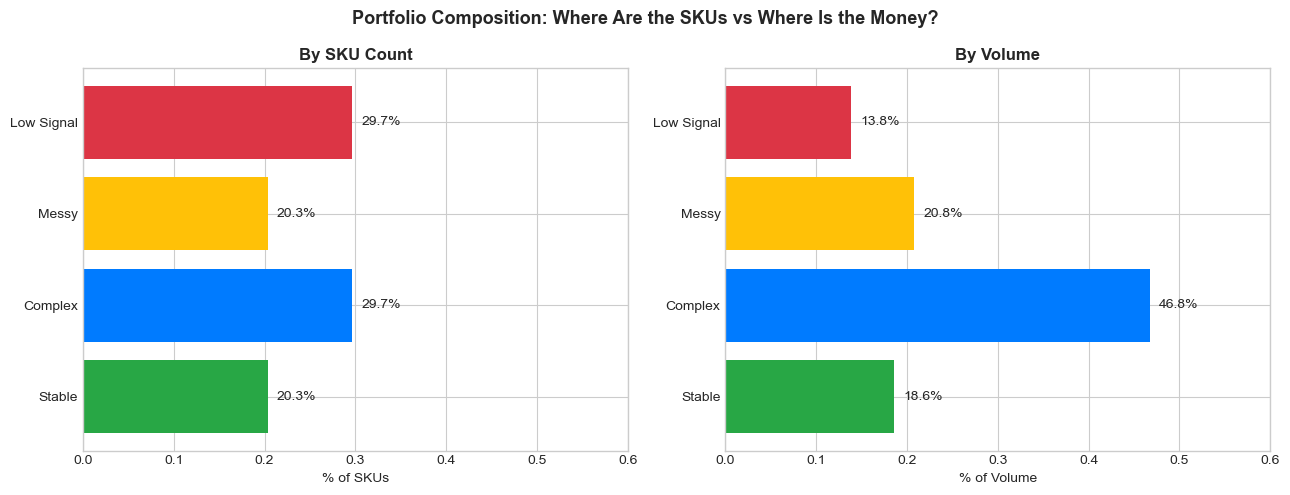

In [17]:
fig = plot_portfolio_composition(portfolio_df)
plt.show()

---

## 9. Risk Matrix (Department × Archetype)

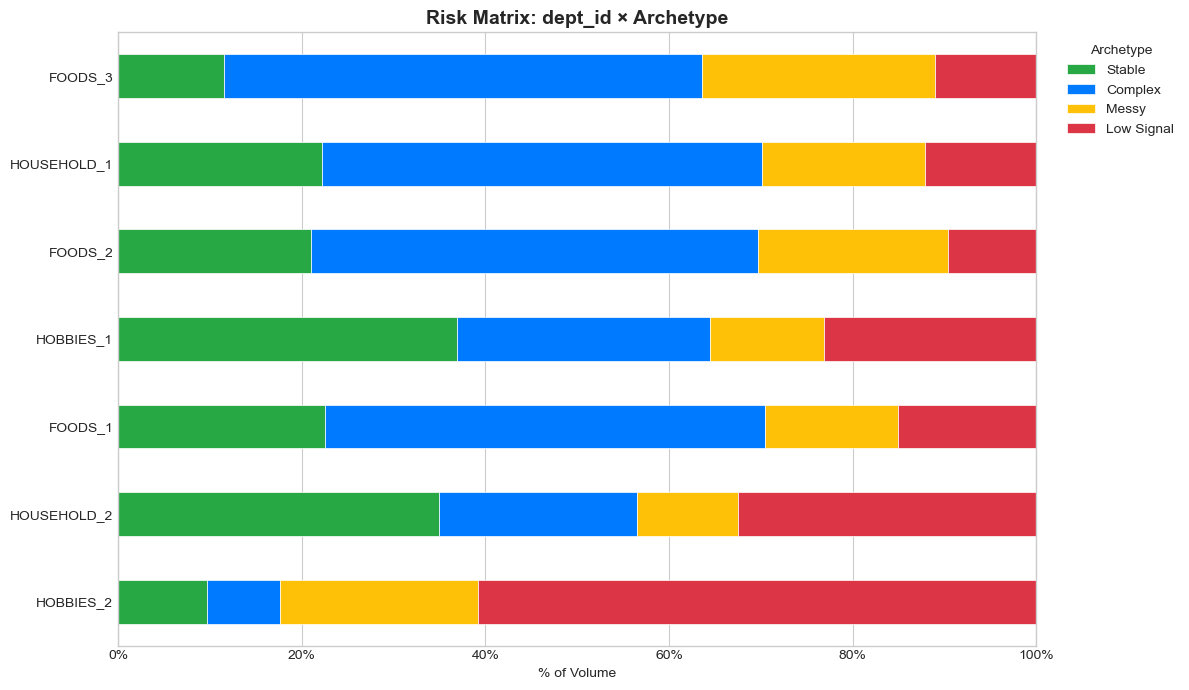

In [18]:
fig, risk_matrix = plot_risk_matrix(portfolio_df, 'dept_id')
plt.show()

In [ ]:
# Risk insights
insights = generate_risk_insights(risk_matrix)
print("Risk Matrix Insights")
print("=" * 65)
for insight in insights:
    print(f"  {insight}")

In [ ]:
# Heatmap view
fig = plot_risk_heatmap(risk_matrix)
plt.show()

---

## 10. Department Aggregates (Scale Context Only)

> ⚠ **Guardrail:** Aggregation hides chaos. These are for *scale context*, not classification.

In [ ]:
fig = plot_department_aggregates(weekly_df, top_n=4)
plt.show()

---

## 11. Save & Handoff

In [ ]:
# Output columns
keep_cols = [
    'unique_id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
    'structure_score', 'chaos_score', 'sb_quadrant',
    'total_volume', 'total_revenue', 'abc_volume', 'abc_revenue', 'archetype'
]
keep_cols = [c for c in keep_cols if c in portfolio_df.columns]

portfolio_output = portfolio_df[keep_cols].copy()
print(f"Output: {len(portfolio_output):,} series × {len(keep_cols)} columns")
portfolio_output.head()

In [ ]:
# Summary
print("=" * 60)
print("MODULE 1.12 SUMMARY")
print("=" * 60)
print(f"\nSeries: {len(portfolio_output):,}")
print(f"\nThresholds: Structure={struct_thresh:.3f}, Chaos={chaos_thresh:.3f}")

print(f"\nABC by Volume:")
for c in ['A', 'B', 'C']:
    n = (portfolio_output['abc_volume'] == c).sum()
    print(f"  {c}: {n:,} ({n/len(portfolio_output):.1%})")

print(f"\nABC by Revenue:")
for c in ['A', 'B', 'C']:
    n = (portfolio_output['abc_revenue'] == c).sum()
    print(f"  {c}: {n:,} ({n/len(portfolio_output):.1%})")

print(f"\nArchetype Distribution:")
for a in ['Stable', 'Complex', 'Messy', 'Low Signal']:
    n = (portfolio_output['archetype'] == a).sum()
    print(f"  {a:<12}: {n:,} ({n/len(portfolio_output):.1%})")

In [ ]:
# Save
output.save(df=portfolio_output, name='1.12_portfolio_architecture')

In [ ]:
# Handoff JSON
handoff = {
    'module': '1.12',
    'series_count': len(portfolio_output),
    'thresholds': {
        'structure': float(struct_thresh),
        'chaos': float(chaos_thresh),
    },
    'abc_volume_distribution': portfolio_output['abc_volume'].value_counts().to_dict(),
    'abc_revenue_distribution': portfolio_output['abc_revenue'].value_counts().to_dict(),
    'archetype_distribution': portfolio_output['archetype'].value_counts().to_dict(),
    'heroes': heroes.to_dict('records'),
    'mismatch_pct': mismatch_info['mismatch_pct'],
}

with open(env.OUTPUT_DIR / '1.12_handoff.json', 'w') as f:
    json.dump(handoff, f, indent=2, default=str)
print("✓ Handoff saved")

---

## 12. Key Takeaways

### The Four Archetypes

| Archetype | Pattern? | Noise? | Strategy |
|-----------|----------|--------|----------|
| **Stable** | Low | Low | Simple baseline, automate |
| **Complex** | High | Low | Invest in ML |
| **Messy** | High | High | Robust methods, human oversight |
| **Low Signal** | Low | High | Aggregate up, baseline only |

### Key Questions Answered

1. **Where is the money?** ABC shows vital few vs trivial many
2. **Units vs Dollars?** Volume ABC ≠ Revenue ABC — know the difference
3. **Where is the risk?** Risk matrix shows department × archetype concentration
4. **What strategy per series?** Archetype → modeling approach

### Next Steps

| Module | Focus |
|--------|-------|
| 2.01 | Baseline models by archetype |